## Scale - Invariant Feature Transform (SIFT)

#### 1.Introduction 
Trong các bài toán Computer Vision, việc có thể export ra được những features luôn đóng góp những thứ quan trọng mà ta có thể sử dụng cho các bài toán khác. Chẳng hạn như trong các bài toán nhận diện vật thể, nếu một bức ảnh có người, nếu ta export ra được một số feature như mắt hay mũi, ta có thể đoán được đó là ảnh con người.  

Trước khi có sự bùng nổ của DeepLearning (xảy ra ở những năm gần đây), chúng ta hay xử lý những vấn đề phân loại ảnh như thế này bằng việc tạo ra các feature từ những bức ảnh, và dựa vào đó xây dựng một thuật toán classification.  

Chất lượng của những feature được detected có ảnh hưởng rất quan trọng đến mục tiêu phân loại của ta. Rất nhiều thuật toán cũng đã được đề xuất để tạo ra được features mà thỏa mãn những tính chất nào đó.  

Trong notebook này, xin giới thiệu về thuật toán SIFT, một thuật toán rất nổi tiếng trong xử lý ảnh. Link paper có thể được tìm thấy tại [đây](https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf).  

Ý tưởng xuất phát từ SIFT đó là việc tạo ra những features không đổi, chẳng hạn như nếu chúng ta có 2 bức ảnh giống nhau, chỉ khác nhau ở size ảnh, thì ta luôn muốn những features được detected trong mỗi bức ảnh là như nhau, hay nếu ta xoay bức ảnh đi, thì ta mong muốn rằng feature được detected so với ảnh gốc hầu như không thay đổi, hay nếu ta thay đổi về điều kiện chiếu sáng,... Không phải thuật toán nào cũng đạt được invariance như thế này. Và SIFT, theo như tác giả đã viết, đạt được tất cả những thứ này. Do vậy ta mới gọi nó là invariant feature.  

Giải thuật SIFT sẽ trả về những features bao gồm keypoints và descriptor cho từng keypoints. Keypoints phản ánh vị trí của feature trong scale space, còn descriptor sẽ thể hiện cho từng keypoints.  

SIFT paper tương đối khó hiểu, và khi viết notebook này, nhiều chỗ trong paper tôi vẫn chưa rõ. SIFT được implement hoàn toàn ở module ``opencv_contrib``. Notebook này chỉ có tác dụng mô tả ngắn gọn các bước của SIFT, thực hiện những chỗ mà tôi hiểu được (nói chung là implementation trong paper này không hoàn toàn chính xác đâu). Còn về việc áp dụng SIFT trong các bài toán khác, chúng ta cứ gọi trực tiếp nó ra từ module ``OpenCV``.  

Không xàm lìn dài dòng nữa, sau đây tôi xin tóm tắt các bước của SIFT.  
- **Scale-space extrema detection**: Tìm toàn bộ trên location và scales (tí nữa sẽ nói rõ hơn về scale) để phát hiện những vị trí có khả năng cao là keypoints.  
- **Keypoints localization**: Từ những potential keypoints, xây dựng threshold để loại bỏ những keypoints có contrast thấp, những keypoints nằm trên các đường cạnh.  
- **Orientation assignment**: Một hay nhiều orientations sẽ được gán cho keypoints. Điều này sẽ tạo ra rotation invariance.  
- **Keypoint descriptor**: Lập ra những descriptor nhằm mục đích vector hóa mỗi keypoint.  

#### 2.Detection of scale-space extrema

Đầu tiên là phải tìm những potential keypoints. Những potential keypoints có thể được tìm thấy thông qua **Laplacian of Gaussian** hay **LoG** ($\sigma^2\nabla^2G$), được đề xuất bởi Lindeberg (1994). Tuy vậy việc tính toán LoG khá là phức tạp, và tác giả đã xấp xỉ nó bằng **Difference of Gaussian** (**DoG**).  

Gọi G là Gausian Function, giống như trong Gauss Filter, trong không gian $(x,y,\sigma)$, G được tính như sau:  
\\[G(x,y,\sigma)=\frac{1}{2\pi\sigma^2}\exp{\{-\frac{x^2+y^2}{2\sigma^2}\}}\\]
Ở đây, ta thêm 1 chiều $\sigma$ vào, và gọi không gian $(x,y,\sigma)$ là scale-space.  
Ta định nghĩa:
\\[L(x,y,\sigma)=G(x,y,\sigma)*I(x,y)\\]
trong đó toán tử * là toán tử convolve.  
LoG được tính như sau:
\\[\sigma\nabla^2G=\frac{\partial G}{\partial \sigma}\\]

Ta sử dụng xấp xỉ đạo hàm, ta có:
\\[\sigma\nabla^2G=\frac{\partial G}{\partial \sigma} \approx \frac{G(x,y,k\sigma)-G(x,y,\sigma)}{k\sigma-\sigma}\\]

Hay:
\\[G(x,y,k\sigma)-G(x,y,\sigma)=(k-1)\sigma^2\nabla^2G\\]
Ta định nghĩa DoG như sau:
\\[D(x,y,\sigma)=G(x,y,k\sigma)-G(x,y,\sigma)\\]

Như vậy qua các biểu thức trên ta đã phản ánh được mối quan hệ giữa DoG và LoG.  

Bây giờ, ta thử import các thư viện và load ảnh vào notebook

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

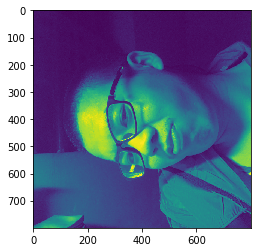

In [2]:
# For simplicity we only use grayscale image
img=cv2.imread('Images/IMG_0851.JPG',0)
img=cv2.resize(img,(800,800)) # We use a small size of the image
%matplotlib inline
plt.imshow(img)
plt.show()

Tiếp theo, ta cần xây dựng một pyramid of Gaussian Blur và pyramid of DoG. Để đạt được điều này, ta sẽ thực hiện Gaussian Blur liên tiếp với $\sigma$ tăng dần. Chúng ta sẽ chia không gian thực hiện Gaussian Blur thành nhiều octave, mỗi octave tương ứng với size của image bị giảm đi 2 lần. Mỗi khi thực hiện xong một octave, có nghĩa là ta đã thực hiện Gassian Blur lên ảnh gấp đôi khi mới ở đầu octave.  

Giả sử rằng ta muốn mỗi octave chứa s images, mỗi image được convolve với $\sigma$ chênh nhau bằng một hằng số $k$. Để có thể có bức ảnh cuối octave có blurring scaling gấp đôi, thì khi đó ta chọn $k=2^{1/s}$. Sau đó tại mỗi octave, ta substract 2 images liên tiếp nhau trong Blurring octave để thu được một DOG Octave. Trong thực tế, để giữ cho DoG octave có số lượng image là s, thì ta sẽ tạo ra s+3 images trong Blurring Images. Như vậy thì khi substract, ở DoG có s+2 images, 2 images đầu và cuối sẽ bị bỏ đi(tí nữa giải thích sau) mới được s images. Cụ thể là như trong ảnh sau:  
![](Images/pyramid.png)

In [3]:
def generate_octave_blur(img,nlayers,sigma):
    '''
    Generate the Gaussian layers in an Octave by Gaussian Blur
    Parameters:
    img: the image of the last octave that standard deviation is twice as in the begin of the sigma
    nlayers: number of layers in an octave
    sigma: standard deviation
    '''
    size=2*int(3*sigma)+1 #size of the kernel filter
    k=2**(1/nlayers)
    sig=np.zeros((nlayers+3,)) #generate the sigma for each layer
    sig[0]=sigma
    for i in range(1,nlayers+3):
        sig_prev=np.power(k,i-1)*sigma
        sig_total=k*sig_prev
        sig[i]=np.sqrt(sig_total*sig_total-sig_prev*sig_prev)
    octave_img=np.zeros((img.shape[0],img.shape[1],nlayers+3)).astype(np.uint8) #initialize the octave_img for the whole octave
    octave_img[:,:,0]=img
    for i in range(1,nlayers+3):
        octave_img[:,:,i]=cv2.GaussianBlur(img,(size,size),sig[i])
    return octave_img,sig

In [4]:
_,sig=generate_octave_blur(img,nlayers=3,sigma=1.6)
print(sig)

[1.6        1.2262735  1.54500779 1.94658784 2.452547   3.09001559]


In [5]:
def generate_pyramid_blur(img,nlayers,noctaves,sigma):
    '''
    Generate the pyramid blur for the image. Parameters:
    img: image
    nlayers: number of layers in an octave
    noctaves: number of octaves
    sigma: standard deviation of Gaussian Filter
    '''
    pyr=[] #initilize the list pyramid
    for i in range(noctaves):
        octave_img,_=generate_octave_blur(img,nlayers,sigma)
        pyr.append(octave_img)
        img=cv2.resize(octave_img[:,:,nlayers+1],(img.shape[0]//2,img.shape[1]//2),cv2.INTER_NEAREST)
    return pyr

Octave 1


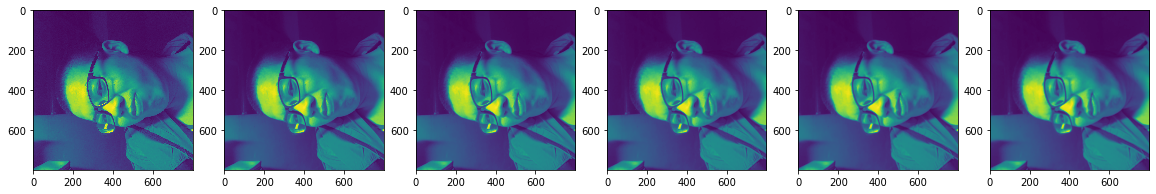

Octave 2


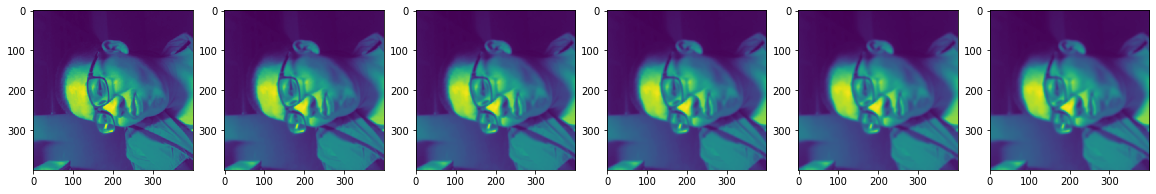

Octave 3


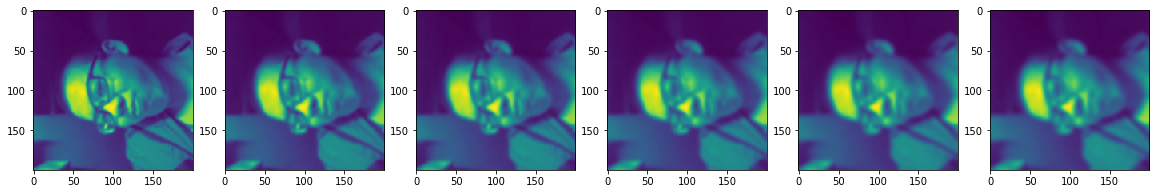

Octave 4


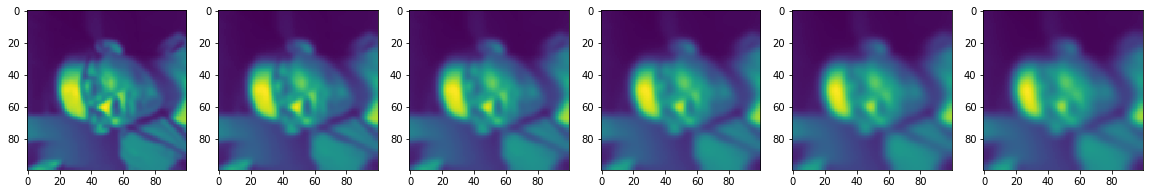

In [6]:
# Let's construct our pyramid
pyr=generate_pyramid_blur(img,nlayers=3,noctaves=4,sigma=1.6)
nrows=1;ncols=6 #we set each octave in a line, comprises of 6 column
for octave in range(4):
    print('Octave '+str(octave+1))
    %matplotlib inline
    fig=plt.figure(figsize=(20,20))
    for i in range(1,nrows*ncols+1):
        image=pyr[octave][:,:,i-1]
        fig.add_subplot(nrows,ncols,i)
        plt.imshow(image)
    plt.show()

In [7]:
def generate_DoG_octave(octave_img):
    '''
    For generating the DoG image in each octave
    Parameters:
    octave_img: the image in the octave (numpy array)
    '''
    nimages=octave_img.shape[2]
    DoG_img=np.zeros((octave_img.shape[0],octave_img.shape[1],nimages-1)).astype(np.uint8)
    for i in range(nimages-1):
        DoG_img[:,:,i]=cv2.subtract(octave_img[:,:,i+1],octave_img[:,:,i])
    return DoG_img

In [8]:
def generate_DoG_pyramid(pyr):
    '''
    Generate the pyramid for DoG
    Parameters:
    pyr: the pyramid (list)
    '''
    DoG_pyr=[]
    for octave in pyr:
        DoG_pyr.append(generate_DoG_octave(octave_img=octave))
    return DoG_pyr

Octave 1


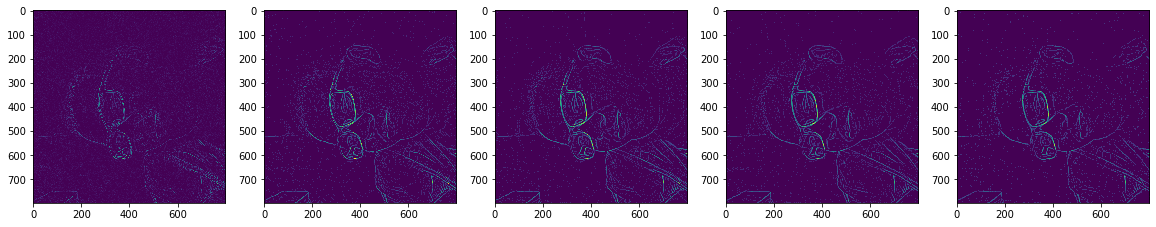

Octave 2


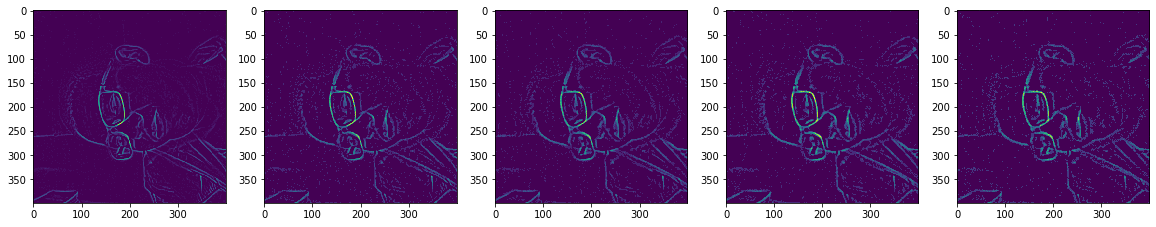

Octave 3


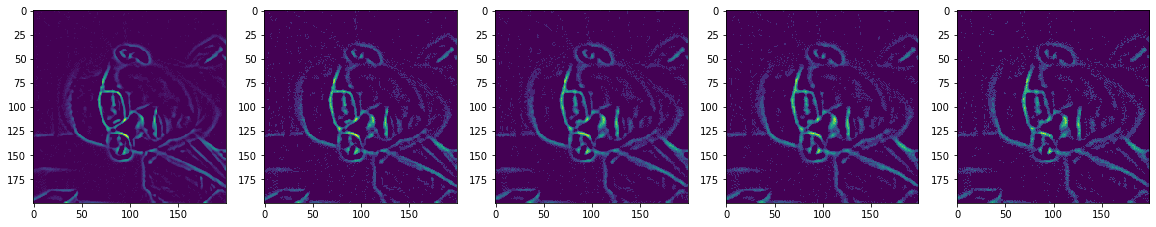

Octave 4


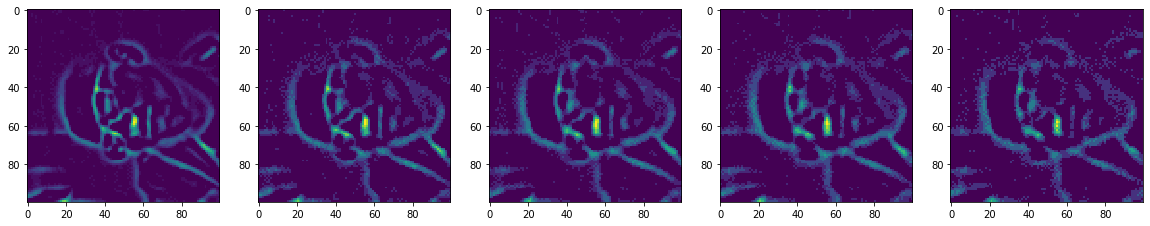

In [9]:
DoG_pyr=generate_DoG_pyramid(pyr)
nrows=1;ncols=5
for octave_idx in range(len(DoG_pyr)):
    print('Octave '+str(octave_idx+1))
    %matplotlib inline
    fig=plt.figure(figsize=(20,20))
    for i in range(1,nrows*ncols+1):
        image=DoG_pyr[octave_idx][:,:,i-1]
        fig.add_subplot(nrows,ncols,i)
        plt.imshow(image)
    plt.show()

Như vậy là đã xây dựng pyramid cho các octave. Từ đầu đến đây có vẻ rất đơn giản. Bây giờ ta sẽ xác định các potential extrema.  
Bây giờ để xác định các potential extrema, ta sẽ thực hiện trên DoG pyramid. Các maxima và minima được xác định như sau: Mỗi điểm trong DoG sẽ được so sánh với 8 điểm kề với nó, và được so sánh với 9 điểm ở scale dưới và 9 điểm ở scale trên. Nếu điểm này mà lớn hơn tất cả 26 điểm đó hay nhỏ hơn tất cả thì nó được gọi là maxima hoặc minima. Việc tìm kiếm các extrema được mô tả trong hình sau:  
![](Images/Figure2.png)


Có một điều nữa để nói thêm trong phần này, đó là việc chọn số lượng scale trong một octave và xác định $\sigma$. Trong paper, tác giả đã sử dụng những bức ảnh khác nhau (base image), và thực hiện một số chuyển đổi đối với những bức ảnh này (như rotate, scaling, add noise, change the illumination,...). Sau đó thực hiện matching giữa những keypoints detected được từ những transformed image, sau đó tính toán tỉ lệ match đúng, được gọi là repeatability trong paper. 

Tác giả chỉ ra rằng với số lượng layers tại mỗi octave là 3 và $\sigma=1.6$ là tốt để thực hiện. Do vậy, tôi cũng chọn nlayers=3 và $\sigma=1.6$ ở trong implementation phía trên.  

Trước khi tiếp tục, chúng ta sẽ đưa range của từng pixel về đoạn $[0,1]$ (trong paper tác giả chủ yếu làm trên $[0,1]$. Để đạt được điểu này, đơn giản bằng cách chia các ma trận trong DoG pyramid cho 255.  

In [10]:
def convert_range(DoG_pyr):
    '''
    convert the DoG_pyr from range 0-255 to range [0,1]
    Parameters:
    DoG_pyr: pyramid, list of numpy array in range 0-255
    '''
    new_DoG_pyr=[]
    for DoG_octave in DoG_pyr:
        new_DoG_pyr.append(DoG_octave/255)
    return new_DoG_pyr

In [11]:
DoG_pyr=convert_range(DoG_pyr)
print('Range in octave 1: '+str(np.min(DoG_pyr[0]))+' '+str(np.max(DoG_pyr[0])))
print('Range in octave 2: '+str(np.min(DoG_pyr[1]))+' '+str(np.max(DoG_pyr[1])))
print('Range in octave 3: '+str(np.min(DoG_pyr[2]))+' '+str(np.max(DoG_pyr[2])))
print('Range in octave 4: '+str(np.min(DoG_pyr[3]))+' '+str(np.max(DoG_pyr[3])))

Range in octave 1: 0.0 0.2196078431372549
Range in octave 2: 0.0 0.11372549019607843
Range in octave 3: 0.0 0.09411764705882353
Range in octave 4: 0.0 0.09803921568627451


In [12]:
def check_for_scale_extrema(previous_slice,current_slice,next_slice):
    '''
    Check for a point to be the extrema.
    Parameters:
    previous_slice: the neighbors in previous scale, (3,3) numpy array
    current_slice: the neighbors in current scale, (3,3) numpy array
    next_slice: the neighbors in next scale, (3,3) numpy array
    '''
    point=current_slice[1,1]
    if(point>np.max(current_slice[0,:]) and point>current_slice[1,0] and point>current_slice[1,2] and point>np.max(current_slice[2,:])):
        if(point>np.max(previous_slice) and point >np.max(next_slice)):return True
        else: return False
    elif(point<np.min(current_slice[0,:]) and point<current_slice[1,0] and point<current_slice[1,2] and point<np.min(current_slice[2,:])):
        if(point<np.min(previous_slice) and point < np.min(next_slice)):return True
        else: return False
    return False

In [13]:
def find_potential_extrema_octave(DoG_img,border=10):
    '''
    Find the potential extrema in an DoG octave
    Parameters:
    octave_idx: the index of the octave
    DoG_img: the DoG img in the octave, 3D numpy array
    border: the border to the left, right, top and bottom, which we define the scope for searching the extrema
    '''
    octave_keypoints=[] #initialize the list of keypoints
    nlayers=DoG_img.shape[2]
    for layer_idx in range(1,nlayers-1):
        for y in range(border,DoG_img.shape[0]-border):
            for x in range(border,DoG_img.shape[1]-border):
                current_slice=DoG_img[y-1:y+2,x-1:x+2,layer_idx] #Extract the slice of neighbors in the current layer
                previous_slice=DoG_img[y-1:y+2,x-1:x+2,layer_idx-1] #Extract the corresponding neighbors in the previous layer
                next_slice=DoG_img[y-1:y+2,x-1:x+2,layer_idx+1] #Extract the corresponding neighbors in the next layer
                if(check_for_scale_extrema(previous_slice,current_slice,next_slice)):octave_keypoints.append([x,y,layer_idx])
    return np.array(octave_keypoints)

In [14]:
def find_potential_extrema_pyr(DoG_pyr,border=10):
    '''
    Find the potential extrema in the pyramid
    Parameters:
    DoG_pyr: DoG pyramid, list of octave_img
    border
    '''
    keypoints=[]
    for octave in DoG_pyr:
        keypoints.append(find_potential_extrema_octave(octave,border))
    return keypoints

In [15]:
pyr_keypoints=find_potential_extrema_pyr(DoG_pyr,border=10)
for octave_idx in range(len(pyr_keypoints)):
    print('Keypoints shape in octave '+str(octave_idx+1)+' :'+str(pyr_keypoints[octave_idx].shape))

Keypoints shape in octave 1 :(1673, 3)
Keypoints shape in octave 2 :(664, 3)
Keypoints shape in octave 3 :(155, 3)
Keypoints shape in octave 4 :(27, 3)


Ok, hi vọng là tôi đúng. Bây giờ chuyển sang bước tiếp theo của thuật toán.

#### 3. Accurate keypoints localization
Khi kết thúc bước trên, chúng ta đã thu được một tập các keypoints. Ở bước này, chúng ta thực hiện một số biện pháp để loại bỏ bớt một số keypoints đi.  
Trước hết, ta loại bỏ những keypoints có contrast thấp. Ở đây, đối với mỗi keypoints, tác giả sử dụng khai triển Taylor:  
\\[D(x)=D+\frac{\partial D^T}{\partial x}x+\frac{1}{2}x^T\frac{\partial^2 D}{\partial x^2}x\\]

Trong đó $x=(x,y,\sigma)$, là tọa độ của keypoint tương ứng trong scale space.  
Vị trí của local extrema, được xác định bằng cách tính đạo hàm của khai triển Taylor $D(x)$ bên trên rồi set về 0, ta có:  
\\[\hat{x}=-\frac{\partial^2 D}{\partial x^2}^{-1}\frac{\partial D}{\partial x}\\]

Nếu giá trị của $\hat{x}$ mà lớn hơn 0.5 ở bất kì chiều nào, có nghĩa rằng extremum sẽ nằm ở vị trí khác, ta tiến hành cập nhật vị trí đó cho keypoints của ta.  

Chúng ta thay giá trị $\hat{x}$ vào biểu thức $D(x)$, khi đó, ta có:  
\\[D(\hat{x})=D+\frac{1}{2}\frac{\partial D}{\partial x}^T\hat{x}\\]
Chúng ta sẽ loại bỏ tất cả keypoints mà $D(\hat{x})<0.03$. Những keypoints được cho là có low contrast trong paper.   
Ở trên kia, ta phải tính toán 2 đạo hàm, đạo hàm: $\frac{\partial D}{\partial x}$ và $\frac{\partial^2 D}{\partial x^2}$. Để có thể thuận tiện cho tính toán, ta sẽ áp dụng hiệu của những ô trong DoG image, cụ thể như sau:  
\\[\frac{\partial D}{\partial x}=\frac{D(y,x+1,\sigma)-D(y,x-1,\sigma)}{2}\\]
\\[\frac{\partial D}{\partial y}=\frac{D(y+1,x,\sigma)-D(y-1,x,\sigma)}{2}\\]
\\[\frac{\partial D}{\partial \sigma}=\frac{D(y,x,\sigma+1)-D(y,x,\sigma-1)}{2}\\]
Các đạo hàm cấp 2 được tính như sau:  
\\[D_{xx}^{''}(y,x,\sigma)=D_x^{'}(y,x+0.5,\sigma)-D_x^{'}(y,x-0.5,\sigma)=(D_x^{'}(y,x+1,\sigma)-D_x^{'}(y,x,\sigma))-(D_x^{'}(y,x,\sigma)-D_x^{'}(y,x-1,\sigma))\\]
\\[=D(y,x+1,\sigma)-2D(y,x,\sigma)+D(y,x,\sigma)\\]

và:
\\[D_{xy}^{''}(y,x,\sigma)=\frac{D_x^{'}(y+1,x,\sigma)-D_x^{'}(y-1,x,\sigma)}{2}\\]
\\[=\frac{((D(y+1,x+1,\sigma)-D(y+1,x-1,\sigma))-(D(y-1,x+1,\sigma)-D(y-1,x-1,\sigma))}{4}\\]

Các đạo hàm khác tính một cách tương tự.

Sau khi loại bỏ những keypoints có low contrast, paper đã nói rằng difference of Gaussian của ta hiện tại có response rất lớn tại các cạnh. Những vị trí trên những cạnh được xác định rất khó, và rất nhạy cảm với nhiễu. Tiếp theo, ta tiến hành loại bỏ những keypoints kiểu này.  
Trong paper đã giải thích rằng một cách khó được xác định ở difference of Gaussian thì sẽ có principle curvatures lớn, và perpendicular direction nhỏ (xin được phép giữ thuật ngữ). Priciple curvatures được tính toán từ Hessian matrix cỡ 2$\times$2 H, được tính tại vị trí của các keypoints (trong không gian scale).  

\\[H=[[D_{xx},D_{xy}],[D_{xy} D_{yy}]]\\]
Principle curtivatures của D được tính theo tỉ lệ của các eigenvalues của H. Trong paper nói rõ rằng chúng ta sẽ không tính trực tiếp các eigenvalues ra, mà sẽ tính tỉ lệ của chúng theo cách sau đây:  

Gọi $\lambda_1,\lambda_2$ là các eigen values của H, như vậy ta có $\lambda_1,\lambda_2$ là nghiệm của phương trình:  

\\[(D_{xx}-x)(D_{yy}-x)-D_{xy}D_{yx}=0\\]

Sử dụng Viet, ta có:

\\[\lambda_1+\lambda_2=D_{xx}+D_{yy}=Trace(H)\\]

\\[\lambda_2\lambda_2=D_{xx}D_{yy}-D_{xy}^2=Det(H)\\]

Trong đó Trace chỉ đơn giản là vết ma trận, còn Det(H) là định thức ma trận thôi.  
Giả sử rằng $\lambda_1\geq\lambda_2$. Khi đó đặt $r=\frac{\lambda_1}{\lambda_2}$. Khi đó $r\geq 1$. Từ đây ta có:  
\\[\frac{Trace(H)^2}{Det(H)}=\frac{(\lambda_1+\lambda_2)^2}{\lambda_1\lambda_2}=\frac{(r+1)^2}{r}\\]

Chúng ta thấy rằng hàm số $\frac{(r+1)^2}{r}$ sẽ đạt giá trị nhỏ nhất khi $r=1$. Theo paper, chúng ta sẽ loại bỏ những keypoints mà có ratio này lớn. Tác giả đã chọn threshold cho r=10.  
Như vậy những keypoints được giữ lại là những keypoints thỏa mãn:  
\\[\frac{Trace(H)^2}{Det(H)}=\frac{(r+1)^2}{r}<\frac{11^2}{10} \approx 10\\]

In [16]:
def calculate_derivatives(D,x,y,s):
    '''
    We calculate the derivatives for localizing the keypoints
    '''
    dx=(D[y,x+1,s]-D[y,x-1,s])/2
    dy=(D[y+1,x,s]-D[y-1,x,s])/2
    ds=(D[y,x,s+1]-D[y,x,s-1])/2
    dxx=(D[y,x+1,s]-2*D[y,x,s]+D[y,x-1,s])
    dyy=(D[y+1,x,s]-2*D[y,x,s]+D[y-1,x,s])
    dss=(D[y,x,s+1]-2*D[y,x,s]+D[y,x,s-1])
    dxy=((D[y+1,x+1,s]-D[y+1,x-1,s])-(D[y-1,x+1,s]-D[y-1,x-1,s]))/4
    dxs=((D[y,x+1,s+1]-D[y,x-1,s+1])-(D[y,x+1,s-1]-D[y,x-1,s-1]))/4
    dys=((D[y+1,x,s+1]-D[y-1,x,s+1])-(D[y+1,x,s-1]-D[y-1,x,s-1]))/4
    first_diff=np.array([[dx],[dy],[ds]])
    second_diff=np.array([[dxx,dxy,dxs],[dxy,dyy,dys],[dxs,dys,dss]])
    return first_diff,second_diff

In [17]:
def relocalize_keypoints_octave(DoG_octave_keypoint,DoG_octave,contrast_thr=0.03,ratio_thr=10):
    '''
    Relocalize keypoints in an octave, using the contrast threshold and edge respond
    Parameters: DoG_octave: 3D numpy array
    '''
    octave_keypoints=[] #Reinitialize the keypoints
    for keypoint in DoG_octave_keypoint:
        x,y,s=keypoint[0],keypoint[1],keypoint[2]
        first_diff,second_diff=calculate_derivatives(DoG_octave,x,y,s)
        x_hat = -np.linalg.pinv(second_diff).dot(first_diff) #calculate the x_hat in the paper
        contrast=DoG_octave[y,x,s]+0.5*first_diff.T.dot(x_hat) #Calculate the D(x_hat) in the paper
        if(contrast[0,0]<contrast_thr):continue #Remove low contrast
        else:
            #Remove the edge response
            Hessian=second_diff[:2,:2] #Retrieve the Hessian matrix
            Trace_Hess=Hessian[0,0]+Hessian[1,1] #Trace of the Hessian matrix
            det_Hess=max(Hessian[0,0]*Hessian[1,1]-Hessian[0,1]*Hessian[1,0],1e-6) #determinant of Hessian matrix
            if(Trace_Hess**2/det_Hess>=ratio_thr):continue #eliminate the keypoint less than ratio_thr
            if(x_hat[0,0]>0.5 or x_hat[1,0]>0.5 or x_hat[2,0]>0.5):
                new_keypoint=np.array([int(round(keypoint[0]+x_hat[0,0])),int(round(keypoint[1]+x_hat[1,0])),int(round(keypoint[2]+x_hat[2,0]))])
                octave_keypoints.append(new_keypoint)
            else:
                octave_keypoints.append(keypoint)
    return np.array(octave_keypoints)

In [18]:
def relocalize_keypoints_pyramid(pyr_keypoints,DoG_pyr,contrast_thr=0.03,ratio_thr=10):
    '''
    Relocalize keypoints for the full pyramid
    '''
    new_pyr_keypoints=[]
    for i in range(len(pyr_keypoints)):
        new_pyr_keypoints.append(relocalize_keypoints_octave(pyr_keypoints[i],DoG_pyr[i],contrast_thr,ratio_thr))
    return new_pyr_keypoints

In [19]:
pyr_keypoints=relocalize_keypoints_pyramid(pyr_keypoints,DoG_pyr)
for i in range(len(pyr_keypoints)):
    print('Shape of keypoints in octave '+str(i)+': '+str(pyr_keypoints[i].shape))

Shape of keypoints in octave 0: (19, 3)
Shape of keypoints in octave 1: (8, 3)
Shape of keypoints in octave 2: (3, 3)
Shape of keypoints in octave 3: (1, 3)


Có vẻ khá ít keypoints mới, hi vọng là vẫn đúng.  
Bây giờ hãy chuyển sang bước tiếp theo của thuật toán, đó là orientation assignment.  
#### 4. Orientation assignment.  
Sau khi thực hiện xong bước 3, chúng ta đã điều chỉnh lại cả về localization của các keypoints, số lượng keypoints bị loại đi là rất nhiều.  
Với việc thực hiện difference of Gaussian trên nhiều scale khác nhau, theo như paper các keypoints đã invariant hơn đối với sự thay đổi về scale, ở bước này, chúng ta sẽ làm model trở nên robust đối với rotation.  
Để thực hiện orientation assignment trong bước này, chúng ta sẽ thực hiện trên Blur Image octave, đối với mỗi keypoints, ta sẽ chọn gaussian blur image tại octave và scale tương ứng.  

Tại mỗi keypoints, ta sẽ xét một gaussian weighted circular quanh keypoints đó, với $\sigma$ của đường tròn bằng 1.5 scale tại keypoints, như vậy, bán kính đường tròn sẽ là $3\sigma$.  
Tại mỗi điểm trong đường tròn, được gọi là sample point trong paper, chúng ta sẽ tính magnitude và orientation tại mỗi điểm đó, sử dụng L là Gaussian blur matrix tương ứng, ta có:  
\\[m(x,y)=\sqrt{(L(x+1,y)-L(x-1,y))^2+(L(x,y+1)-L(x,y-1))^2}\\]

và:
\\[\theta(x,y)=arctan(\frac{L(x,y+1)-L(x,y-1)}{L(x+1,y)-L(x-1,y)})\\]
Lưu ý rằng hàm arctan chỉ trả về một góc từ $[-90,90]$, để đạt được các góc từ $[0,360]$, chúng ta phải xét thêm dấu của tử và mẫu nữa.  
Tại mỗi keypoint, chúng ta tạo ra một orientation histogram, gồm có 36 bins, đại diện cho các góc từ 0-360, mỗi bin sẽ tương ứng với một khoảng là 10. Khi đó sau khi tính xong orientation, ta sẽ cộng vào bin tương ứng của orientation đó một lượng là magnitude nhân với weight của circular weighted window tại vi trí tương ứng.  

Sau đó ta sẽ xét các largest peak của histogram, là giá trị lớn nhất trong histogram, và ta sẽ xét toàn bộ những value khác trong histogram này mà có giá trị lớn hơn 0.8 peak, khi đó những giá trị này cùng với peak sẽ được đem ra làm keypoints. Như vậy keypoints mới sẽ có thêm 1 trường là orientation, mỗi keypoint ban đầu có thể tạo ra nhiều keypoints mới (cùng scale space nhưng khác nhau về orientation).  

Trong paper tác giả còn đó để có thể đạt giá trị chính xác hơn về orientation cho mỗi keypoint, chúng ta sử dụng nội suy bậc 2 cho 3 điểm (peak và 2 giá trị kề với nó). Tuy nhiên tôi vẫn chưa rõ là nội suy bậc 2 này là như thế nào, nên vẫn chưa trình bày trong implementation.  

In [20]:
def cal_mag_and_orientation(x,y,gauss_img):
    '''
    Calculate the magnitude and orientation for the gauss_img at location x and y
    Parameters:
    x,y: 2 intergers represent the location
    gauss_img: the gaussian image, np.uint8 data type 
    '''
    diff1=int(gauss_img[y,x+1])-int(gauss_img[y,x-1])
    if(np.abs(diff1)<1e-6):diff1=1e-6
    diff2=int(gauss_img[y+1,x])-int(gauss_img[y-1,x])
    if(np.abs(diff2)<1e-6):diff2=1e-6
    mag=np.sqrt(diff1**2+diff2**2)
    # We calculate for each case to retrive the angle from -180 to 180
    ori=np.rad2deg(np.arctan2(diff2,diff1))
    return mag,ori

In [21]:
def assign_orientation_octave(octave_gauss_img,octave_keypoints,sig,scale_factor=1.5,nbins=36,peak_thr=0.8):
    '''
    Assign the orientation for each keypoint in an octave
    Parameters: octave_gauss_img: the gaussian image in that octave, 3D numpy array
    octave_keypoints: numpy array, represent the keypoints in an octave
    sig: the array sigma we use to blur the image
    scale_factor: the scale factor for Gaussian weighted circular window
    nbins: number of bin in the histogram
    '''
    new_keypoints=[] #Initialize the new keypoints
    for keypoint in octave_keypoints:
        x,y,s=keypoint[0],keypoint[1],keypoint[2] #coordinate in the scale space
        hist=np.zeros((nbins,)) #Initialize the histogram
        sigma=1.5*sig[s] # Sigma of the circular window
        radius=int(round(3*sigma)) #Radious of the circular window
        #Define the start and finish of the circular windows
        x_start=max(0,x-radius);x_end=min(octave_gauss_img.shape[1],x+radius)
        y_start=max(0,y-radius);y_end=min(octave_gauss_img.shape[0],y+radius)
        for i in range(y_start,y_end+1):
            for j in range(x_start,x_end+1):
                mag,ori=cal_mag_and_orientation(j,i,gauss_img=octave_gauss_img[:,:,s])
                weight_factor=1/(np.sqrt(2*np.pi)*sigma)
                weight=weight_factor*np.exp(-((x-j)**2+(y-i)**2)/(2*sigma**2))
                hist_indx=int(round(nbins*ori/360)) #index in the histogram of the current point
                hist[hist_indx%nbins]+=weight*mag #Add the weighted magnitude to the histogram
        peak_value=np.max(hist) #peak in the histogram
        peak_idx=np.where(hist>=peak_thr*peak_value)[0] #Index of peak that greater than 0.8 the peak value
        for idx in peak_idx:
            new_keypoints.append([x,y,s,idx*10]) # add a new orientation to new keypoint list
    return np.array(new_keypoints)

In [22]:
def assign_orientation_pyr(pyr_gauss_img,pyr_keypoints,sig,scale_factor=1.5,nbins=36,peak_thr=0.8):
    '''
    Assign the orientation for all image in the octave
    '''
    new_pyr_keypoints=[]
    for i in range(len(pyr_keypoints)):
        octave_gauss_img=pyr_gauss_img[i]
        octave_keypoints=pyr_keypoints[i]
        new_pyr_keypoints.append(assign_orientation_octave(octave_gauss_img,octave_keypoints,sig,scale_factor,nbins,peak_thr))
    return new_pyr_keypoints

In [23]:
pyr_keypoints=assign_orientation_pyr(pyr,pyr_keypoints,sig)
print('Shape of each octave keypoints')
for octave_keypoints in pyr_keypoints:
    print(octave_keypoints.shape)

Shape of each octave keypoints
(28, 4)
(8, 4)
(4, 4)
(1, 4)


Vậy là cuối cũng cũng đã xong việc tìm các keypoints, bây giờ ta sẽ chuyển sang bước cuối cùng đó là các định các descriptors cho các keypoints.  
#### 4. Local image descriptors
Trong paper, tác giả cho rằng khi thực hiện việc tìm các keypoints ở các bước trước, ta đã thành công trong việc tạo ra các features invariant đối với scale, shape hay rotation. Các descriptors ngoài tác dụng mô tả cho các keypoints, còn có thể làm cho model của ta robust đối với các tác nhân khác như thay đổi cường độ chiếu sáng, tầm nhìn,...  

Chúng ta sẽ tìm 1 region (16,16) xung quanh mỗi keypoint, và tạo ra được một Gaussian weighted function mà có $\sigma$ gấp 1.5 lần chiều rộng của region đó. Việc này được mô tả trong hình sau:  
![](Images/Figure3.png)

Lưu ý rằng trong sơ đồ trên, chỉ vẽ một region (8,8). Tuy nhiên tác giả khẳng định rằng sẽ là hiệu quả nhất đối với region (16,16).  

Tại mỗi sample point trong region, ta tính toán magnitude và orientation cho mỗi sample point đó (giống như tại section trên). Khi đó ta thu được một ma trận (16,16) magnitude và orientation.  

Sau đó các magnitudes sẽ được nhân với gaussian window tương ứng mà ta vừa tạo ra, việc này, theo như tác giả giải thích, sẽ làm mượt các magnitudes, tránh được sự thay đổi đột ngột của descriptor khi mà có một ít thay đổi đối với ảnh.  

Sau đó chúng ta chia region của chúng ta thành 16 subregion, mỗi subregion chiếm một khoảng là (4,4). Tại mỗi subregion, ta sẽ tạo ra một histogram gồm 8 bins, thể hiện góc quay từ 0-360. Tuy nhiên, orientation phải compute lại (trừ đi orientation của keypoint). Tác giả còn nói thêm là mỗi khi add vào bin, ta sẽ phải nhân tiếp với mội trọng số (1-d), với d được suy ra từ trilinear interpolation (cái này vẫn chưa rõ lắm nên chưa implement được).  

Khi đó tổng hợp lại 16 subregions, ta sẽ có được một vector 128 chiều, và vector này sẽ làm descriptor cho keypoint đó. Tuy nhiên, tác giả nói thêm rằng để hạn chế ảnh hưởng của sự thay đổi về ánh sáng, thì chúng ta sẽ noramlize vector này (sử dụng L2 norm). Và để hạn chế thêm non-linear illumination, khi đó chúng ta sẽ set threshold cho phần tử của vector descriptor là 0.2. Tất cả những phần tử có giá trị lớn hơn 0.2 được quy về 0.2. Và vector của ta sẽ được renormalized một lần nữa.  

In [24]:
def generate_gaussian_weighted_kernel(sigma,size):
    '''
    Generate a gaussian kernel with standard deviation sigma, extract the corresponding size for the gaussian windows
    '''
    x,y=np.arange(-size//2+1,size//2+1),np.arange(-size//2+1,size//2+1)
    x,y=np.meshgrid(x,y)
    kernel=np.exp(-(x**2+y**2)/(2*sigma**2))/(2*np.pi*sigma**2)
    return kernel

In [25]:
def cal_patch_mag_ori(prev_patch_x,prev_patch_y,next_patch_x,next_patch_y):
    '''
    Calculate the magnitude and orientation for the current patch
    prev_patch_x,prev_patch_y: push the current patch back by 1 in x dimension and y in y dimension
    next_patch_x,next_patch_y: push the current patch forward by 1 in x dimension and y by 1 in y dimension
    This is like what we did in section above, except this is for the whole patch image
    '''
    diffx=next_patch_x-prev_patch_x
    diffx[np.where(np.abs(diffx)<1e-6)]=1e-6 #avoid devided by zero
    diffy=next_patch_y-prev_patch_y
    diffy[np.where(np.abs(diffy)<1e-6)]=1e-6 #advoid devided by zero
    mag=np.sqrt(diffx**2+diffy**2)
    ori=np.rad2deg(np.arctan2(diffy,diffx))
    return mag,ori

In [26]:
def generate_subregion_hist(sub_mag,sub_ori,reference_ori,nbins=8):
    '''
    Generate the subregion histogram.
    Parameters:
    sub_mag: the magnitude for the subregion
    sub_ori: the orientation for the subregion
    reference_ori: the orientation of that keypoint
    nbins: number of bins for the histogram
    '''
    bin_width=360/nbins #width of the histogram bins
    hist=np.zeros((nbins,)) #Initialize the histogram
    for i in range(sub_mag.shape[0]):
        for j in range(sub_mag.shape[1]):
            angle=(sub_ori[i,j]-reference_ori)%360 #Angle compared to reference orientation
            hist_idx=int(round(angle/bin_width))%nbins
            hist[hist_idx]+=sub_mag[i,j]
    return hist

In [27]:
def get_octave_descriptor(octave_gauss_img,octave_keypoints,window=16,nbins=8,nregions=4):
    '''
    Retrieve the descriptor for each octave keypoints
    Parameters:
    octave_gauss_img: blur gauss image in the octave
    octave_keypoints: the keypoints of the octave
    window: the scope for calculating the descriptor, here is (16,16)
    nbins: number of bins in each subregion for calculating the histogram
    nregions: number of regions
    '''
    octave_descriptor=[] #Initialize the list of histogram
    sigma=1.5*window #The author said that sigma is one half of the descriptor window
    kernel=generate_gaussian_weighted_kernel(sigma,window) #Generate the kernel for descriptor windows
    subregion_size=window//nregions #Size of each subregion
    for keypoint in octave_keypoints:
        x,y,s=keypoint[0],keypoint[1],keypoint[2]
        #Define the region around keypoint
        x_start=max(x-window//2+1,0);x_end=min(x+window//2+1,octave_gauss_img.shape[1])
        y_start=max(y-window//2+1,0);y_end=min(y+window//2+1,octave_gauss_img.shape[0])
        patch=octave_gauss_img[y_start:y_end,x_start:x_end,s] #patch
        # Define the patch
        prev_patch_x=octave_gauss_img[y_start:y_end,x_start-1:x_end-1,s].astype(np.int16)
        next_patch_x=octave_gauss_img[y_start:y_end,x_start+1:x_end+1,s].astype(np.int16)
        prev_patch_y=octave_gauss_img[y_start-1:y_end-1,x_start:x_end,s].astype(np.int16)
        next_patch_y=octave_gauss_img[y_start+1:y_end+1,x_start:x_end,s].astype(np.int16)
        #Return the mag and ori matrix for the current patch
        mag,ori=cal_patch_mag_ori(prev_patch_x,prev_patch_y,next_patch_x,next_patch_y)
        mag*=kernel #Recalulate the magnitude
        hist=np.zeros((nregions*nregions,nbins)) #Initialize the histogram
        for y_idx in range(nregions):
            for x_idx in range(nregions):
                sub_mag=mag[y_idx*subregion_size:(y_idx+1)*subregion_size,x_idx*subregion_size:(x_idx+1)*subregion_size]
                sub_ori=ori[y_idx*subregion_size:(y_idx+1)*subregion_size,x_idx*subregion_size:(x_idx+1)*subregion_size]
                sub_hist=generate_subregion_hist(sub_mag,sub_ori,keypoint[3],nbins)
                hist[y_idx*nregions+x_idx,:]=sub_hist
        hist=hist.flatten() #Flatten the histogram
        hist=hist/np.linalg.norm(hist) #Normalize by unit
        hist[np.where(hist>0.2)]=0.2 #Set all the histogram value greater than 0.2 equal 0.2
        hist=hist/np.linalg.norm(hist) #Normalize the hist once again
        octave_descriptor.append(hist)
    return np.array(octave_descriptor)

In [28]:
def get_pyramid_descriptor(pyr_gauss_img,pyr_keypoints,window=16,nbins=8,nregions=4):
    '''
    Generate the descriptor for each keypoints in the pyramid
    Parameters: 
    pyr_gauss_img: pyramid of gaussian blur image
    pyr_keypoints: pyramid keypoints
    window: scope for calculating the descriptor
    nbins: number of bins in a region
    nregions: number of region for each dimension
    '''
    pyr_descriptors=[]
    for octave_idx in range(len(pyr_gauss_img)):
        octave_gauss_img=pyr_gauss_img[octave_idx]
        octave_keypoints=pyr_keypoints[octave_idx]
        pyr_descriptors.append(get_octave_descriptor(octave_gauss_img,octave_keypoints,window,nbins,nregions))
    return pyr_descriptors

In [30]:
pyr_descriptors=get_pyramid_descriptor(pyr,pyr_keypoints)
print('Shape of octave descriptors:')
for octave_descriptors in pyr_descriptors:
    print(octave_descriptors.shape)

Shape of octave descriptors:
(28, 128)
(8, 128)
(4, 128)
(1, 128)


In [31]:
def retrieve_keypoints_descriptors(pyr_keypoints,pyr_descriptors):
    keypoints=pyr_keypoints[0]
    descriptors=pyr_descriptors[0]
    for idx in range(1,len(pyr_keypoints)):
        keypoints=np.concatenate((keypoints,pyr_keypoints[idx]),axis=0)
        descriptors=np.concatenate((descriptors,pyr_descriptors[idx]),axis=0)
    return keypoints,descriptors

In [32]:
keypoints,descriptors=retrieve_keypoints_descriptors(pyr_keypoints,pyr_descriptors)
print('Keypoints:')
print(keypoints)
print('Descriptors:')
print(descriptors)

Keypoints:
[[378 417   2 350]
 [379 431   2   0]
 [379 439   2   0]
 [368 465   2  60]
 [368 465   2 220]
 [368 465   2 230]
 [347 475   2 250]
 [378 512   2 300]
 [391 522   2 310]
 [391 522   2 320]
 [403 552   2 340]
 [404 558   2 160]
 [404 558   2 340]
 [405 560   2 340]
 [405 563   2 160]
 [405 563   2 340]
 [357 596   2 280]
 [695 689   2 170]
 [695 689   2 300]
 [371 378   3 340]
 [371 378   3 350]
 [371 380   3 350]
 [378 424   3   0]
 [378 424   3 180]
 [364 469   3  60]
 [362 470   3  60]
 [403 555   3 160]
 [403 555   3 340]
 [172 169   2 280]
 [180 176   2 340]
 [182 180   2 340]
 [184 185   2 340]
 [136 186   2 170]
 [188 207   2 350]
 [189 210   2 350]
 [199 271   2 340]
 [ 95 113   2  60]
 [112 113   2 340]
 [112 113   2 350]
 [ 95 145   2 190]
 [ 45  65   2 310]]
Descriptors:
[[0.         0.         0.         ... 0.00655155 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.17417898 

Cuối cùng thì ta cũng thu được tập keypoints và descriptors tương ứng.  
Cuối cùng, ta sẽ đề xuất ứng dụng của SIFT trong một vấn đề, đó là image recognition.  
#### 6.Application: Image Recognition
Ở phần này, chúng ta sẽ thực hiện ý tưởng của mô hình bag-of-words, một mô hình rất hay được sử dụng trong NLP, cũng như Computer Vision.  
Trước khi đi vào thuật toán, ta sẽ giải thích bag-of-words là gì:  
*Trong NLP, bag-of-words là một mô hình để đo tần suất xuất hiện của một lớp từ trong một đoạn văn bản. Tập hợp các từ cần đo tần suất được gọi là words, và bộ mô tả tần suất của chúng đối với mỗi văn bản là bag*.  
Ở đây, trong Computer Vision, chúng ta vẫn chưa có bags và words, và do vậy, nhiệm vụ của ta là tạo ra chúng.  
Ta sử dụng thuật toán k-means cluster cho các keypoints của ta, sử dụng descriptors làm vector cho các keypoints. Words được tạo ra từ trung tâm của các centroids, thông thường thì các words sẽ đại diện cho những features nổi bật, có thể phân biệt các object với nhau  

Khi đó đối với mỗi image, chúng ta sẽ xác định mỗi keypoint của nó nằm trong cluster của word nào. Sau đó tạo một histogram thể hiện tần suất của các keypoints trong image đó đối với bộ words của ta. Đến đây, mỗi ảnh có thể được đại diện bởi một feature vector, các vector này sẽ có cùng kích thước với nhau. Ta có thể sử dụng chúng để train bằng cách sử dụng một thuật toán classifier.  
(Phần này sẽ được đề cập nhiều hơn lúc khác)